In [1]:
library('pROC')

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



In [2]:
point_distance = function(x,y)
    {   return(sqrt((1-x)^2 + (1-y)^2)) }

In [18]:
gameplay_df = read.csv(file = 'gameplay_data_total.csv',header = T)

In [19]:
log_energy = log(gameplay_df$energy,2)
avg_amp = scale(gameplay_df$avg_amp)
max_amp = scale(gameplay_df$max_amp)
energy = scale(gameplay_df$energy)
sids = as.numeric(gameplay_df$sampID)

In [20]:
temp = cbind(avg_amp,energy,max_amp,log_energy)
colnames(temp) = c('avg_amp', 'energy', 'max_amp', 'log_energy')
cor(temp)

,avg_amp,energy,max_amp,log_energy
avg_amp,1.0000000,0.9941658,0.5284487,0.8247906
energy,0.9941658,1.0000000,0.5428230,0.8378286
max_amp,0.5284487,0.5428230,1.0000000,0.4969562
log_energy,0.8247906,0.8378286,0.4969562,1.0000000


# Gameplay Level Model

### Linear model

In [21]:
y_linear = as.numeric(gameplay_df$tremor) - 1
model_linear = lm(y_linear ~ avg_amp + max_amp + log_energy)
summary(model_linear)


Call:
lm(formula = y_linear ~ avg_amp + max_amp + log_energy)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6523 -0.5384  0.3253  0.4447  1.0399 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.56938    0.69863   2.246   0.0251 *  
avg_amp      0.15552    0.03932   3.955 8.74e-05 ***
max_amp     -0.10824    0.02562  -4.225 2.84e-05 ***
log_energy  -0.06257    0.04245  -1.474   0.1411    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4872 on 507 degrees of freedom
Multiple R-squared:  0.05175,	Adjusted R-squared:  0.04614 
F-statistic: 9.224 on 3 and 507 DF,  p-value: 5.977e-06


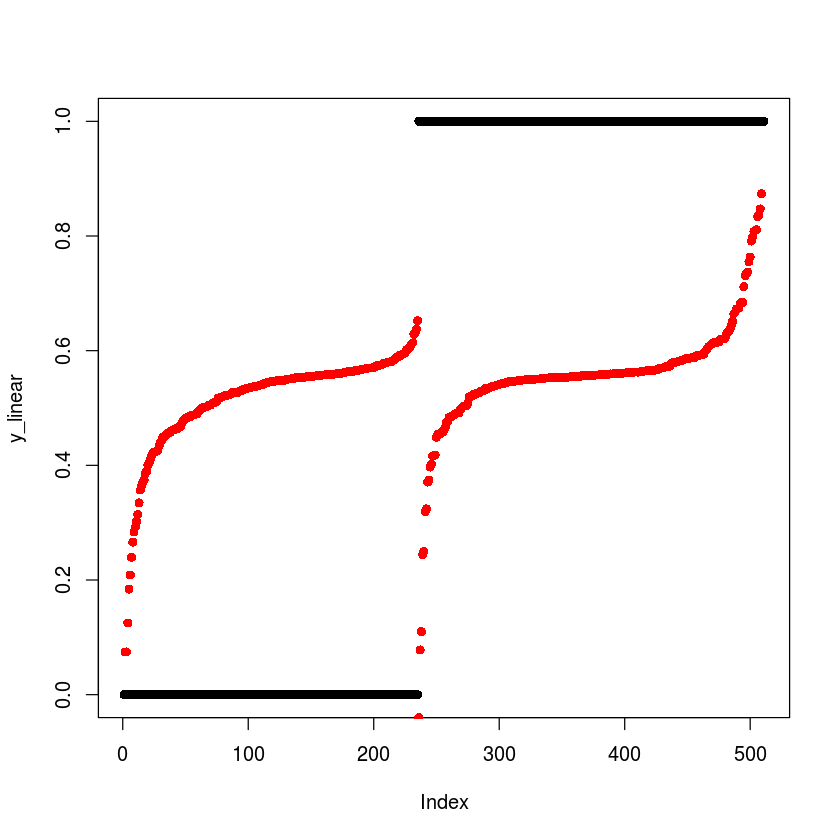

In [22]:
plot(y_linear,pch=16,col='black')
res_linear = fitted(model_linear)
etr = sort(res_linear[which(gameplay_df$tremor == 'ET')])
pdr = sort(res_linear[which(gameplay_df$tremor == 'PD')])

res2 = c(etr,pdr)
points(res2,pch =16,col='red')

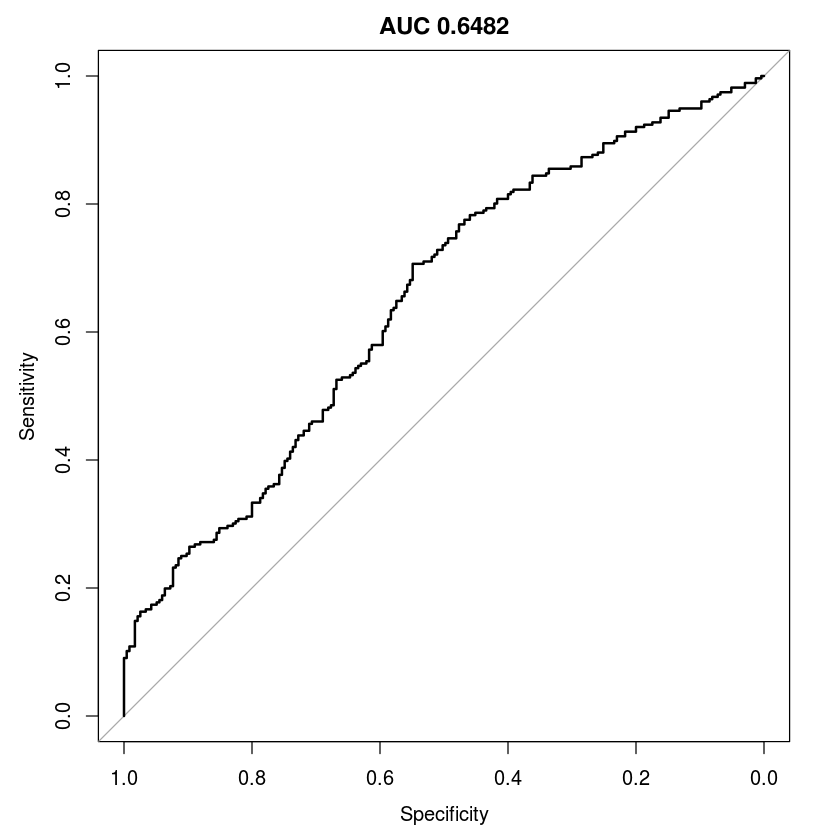

In [23]:
ROC_linear = roc(response = y_linear, predictor = res_linear)
plot.roc(ROC_linear, main = paste('AUC',round(ROC_linear$auc,4)))

# Patient Level Models

## Median Model

In [24]:
patient_disease_status = read.table(file = './data/sample_disease_info.txt', header=T, fill =T, sep = '\t', row.names = 1)
valid_rows = which(row.names(patient_disease_status) %in% gameplay_df$sampID)
patient_disease_status = patient_disease_status[valid_rows,]
head(patient_disease_status)

,disease,pd_history,notes
sc002b,PD,N,
sc007g,PD,N,
sc009i,PD,N,
sc010j,PD,N,
sc011k,PD,N,
sc013m,PD,N,


In [28]:
prediction_results = predict(model_linear)
patient_ids = row.names(patient_disease_status)
actual_disease = patient_disease_status$disease

mean_prediction = c()
median_prediction = c()

for (id in patient_ids)
    {
        pat_ind = which(gameplay_df$sampID == id)
        mean_predicted_score = mean(prediction_results[pat_ind])
        median_predicted_score = median(prediction_results[pat_ind])
        mean_prediction = c(mean_prediction,mean_predicted_score)
        median_prediction = c(median_prediction,median_predicted_score)
    }

In [29]:
y_agg = as.numeric(actual_disease) - 1

In [30]:
model_median = lm(y_agg ~ median_prediction)
res_median = fitted(model_median)
summary(model_median)


Call:
lm(formula = y_agg ~ median_prediction)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7534 -0.4931  0.2268  0.4252  0.6919 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)  
(Intercept)        -0.9861     0.6769  -1.457    0.152  
median_prediction   2.8015     1.2232   2.290    0.027 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4799 on 43 degrees of freedom
Multiple R-squared:  0.1087,	Adjusted R-squared:  0.088 
F-statistic: 5.245 on 1 and 43 DF,  p-value: 0.02697


[1] 0.8

[1] 0.6

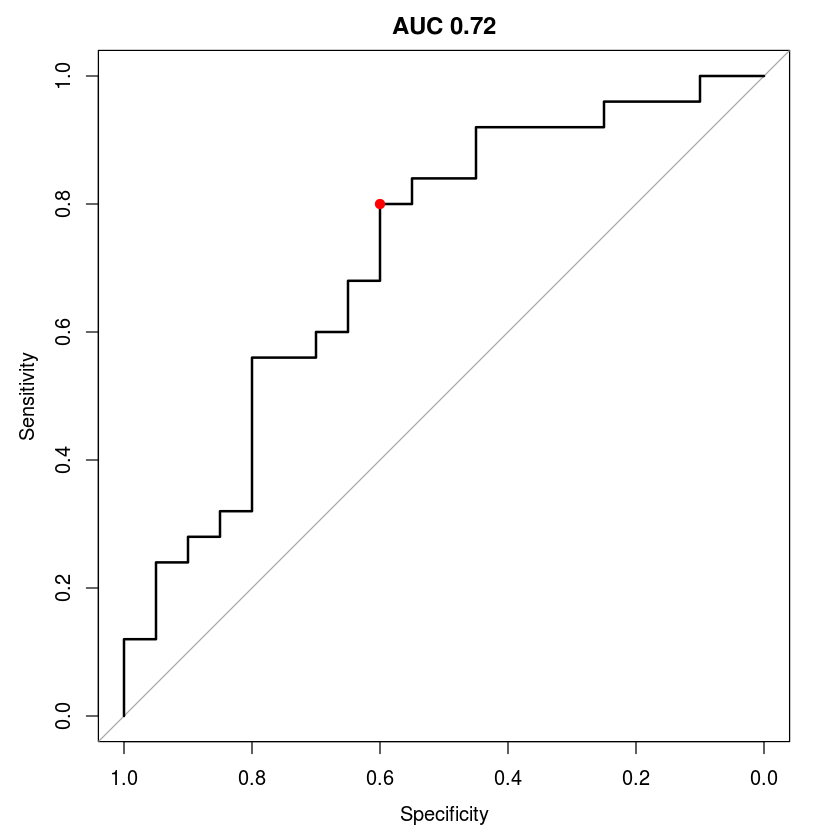

In [31]:
ROC_median = roc(response = y_agg, predictor = res_median)
plot.roc(ROC_median, main = paste('AUC',round(ROC_median$auc,4)))

distances = point_distance(ROC_median$sensitivities, ROC_median$specificities)
best_point = which(distances == min(distances))
points(y = ROC_median$sensitivities[best_point], x = ROC_median$specificities[best_point], col = 'red',pch=19)

ROC_median$sensitivities[best_point]
ROC_median$specificities[best_point]

## Median + GRS Model

In [34]:
patient_pd_grs = read.table(file = './data/genetic_data/snp_grs.txt',col.names = c('user_num','grs'))
head(patient_pd_grs)

user_num,grs
50,2.163376
23,2.805130
27,1.898263
47,1.932916
1,1.932843
57,1.923085


In [35]:
patient_ids_mapping = sapply( (strsplit(x = row.names(patient_disease_status),split = "[[:lower:]]")), `[`, 3)
patient_ids_mapping = as.data.frame(cbind(row.names(patient_disease_status),as.numeric(patient_ids_mapping)))
colnames(patient_ids_mapping) = c('patient_id','patient_num')
head(patient_ids_mapping)

patient_id,patient_num
sc002b,2
sc007g,7
sc009i,9
sc010j,10
sc011k,11
sc013m,13


In [36]:
grs_index = match(patient_ids_mapping$patient_num, patient_pd_grs$user_num)
patient_grs = patient_pd_grs$grs[grs_index]

In [37]:
model_agg = lm(y_agg ~ median_prediction + patient_grs)
res_agg = fitted(model_agg)
summary(model_agg)


Call:
lm(formula = y_agg ~ median_prediction + patient_grs)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7616 -0.4582  0.2118  0.4222  0.7135 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)  
(Intercept)        -0.7309     0.7988  -0.915   0.3654  
median_prediction   2.7718     1.2331   2.248   0.0299 *
patient_grs        -0.1228     0.2002  -0.613   0.5430  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4834 on 42 degrees of freedom
Multiple R-squared:  0.1166,	Adjusted R-squared:  0.07457 
F-statistic: 2.773 on 2 and 42 DF,  p-value: 0.07395


[1] 0.8

[1] 0.65

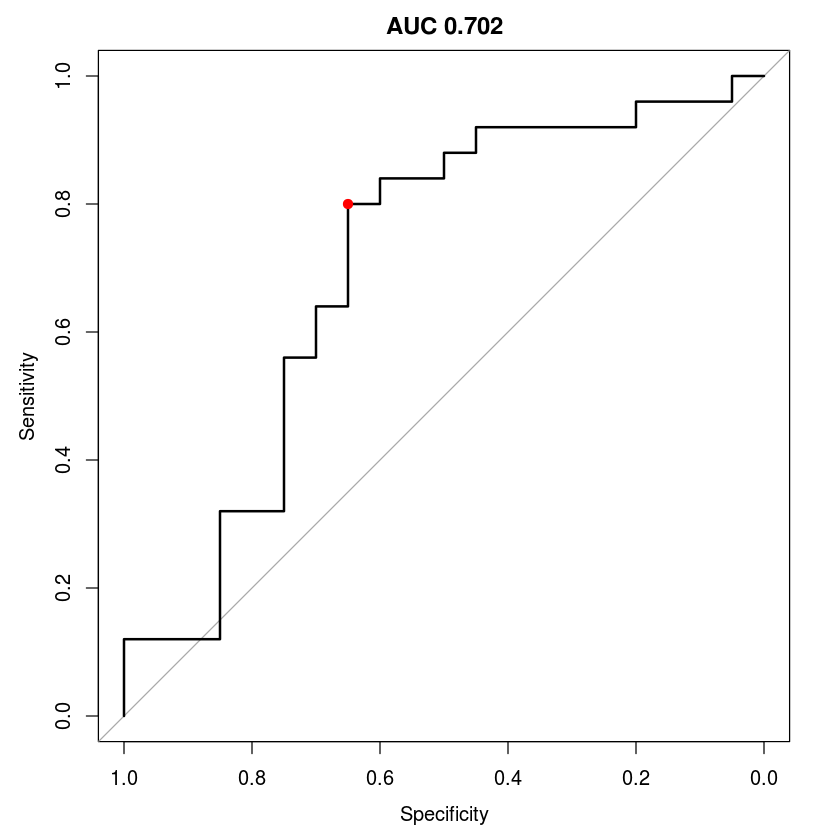

In [38]:
ROC_agg = roc(response = y_agg, predictor = res_agg)
plot.roc(ROC_agg, main = paste('AUC',round(ROC_agg$auc,4)))

distances = point_distance(ROC_agg$sensitivities, ROC_agg$specificities)
best_point = which(distances == min(distances))
points(y = ROC_agg$sensitivities[best_point], x = ROC_agg$specificities[best_point], col = 'red',pch=19)

ROC_agg$sensitivities[best_point]
ROC_agg$specificities[best_point]

### Model with GRS plus Patient PD history

In [43]:
family_history = as.numeric(patient_disease_status$pd_history) - 1
agg_model = lm(y_agg ~ (median_prediction + patient_grs + family_history))
res = fitted(agg_model)
summary(agg_model)


Call:
lm(formula = y_agg ~ (median_prediction + patient_grs + family_history))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7545 -0.4425  0.2190  0.4262  0.7443 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)  
(Intercept)       -0.90541    0.86218  -1.050   0.2998  
median_prediction  2.96565    1.28947   2.300   0.0266 *
patient_grs       -0.09753    0.20666  -0.472   0.6395  
family_history     0.12020    0.21213   0.567   0.5741  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4874 on 41 degrees of freedom
Multiple R-squared:  0.1235,	Adjusted R-squared:  0.05936 
F-statistic: 1.926 on 3 and 41 DF,  p-value: 0.1405


[1] 0.84

[1] 0.65

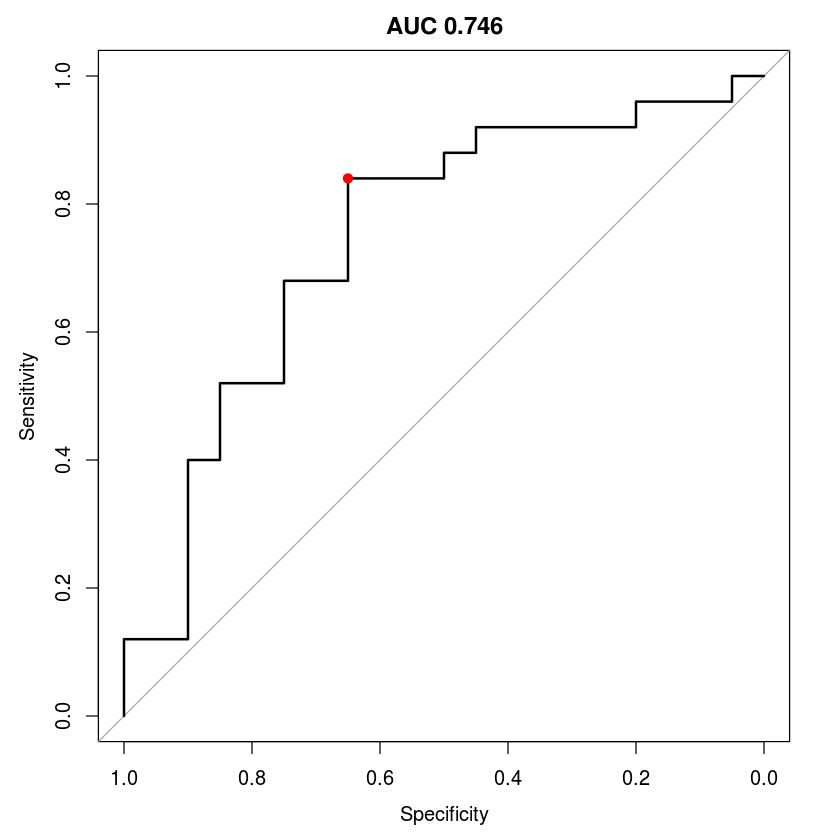

In [44]:
ROC = roc(response = y_agg, predictor = res)
plot.roc(ROC, main = paste('AUC',round(ROC$auc,4)))

distances = point_distance(ROC$sensitivities, ROC$specificities)
best_point = which(distances == min(distances))
points(y = ROC$sensitivities[best_point], x = ROC$specificities[best_point], col = 'red',pch=19)

ROC$sensitivities[best_point]
ROC$specificities[best_point]

## VOTING

In [45]:
mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

SEN = c()
SPE = c()
ACC = c()

for (prob in seq(0,1,0.001))
     {
        results = prediction_results
        results[which(results<prob)] = 'ET'
        results[which(results != 'ET')] = 'PD'
      
        predicted_disease = c()
        for (id in patient_ids)
            {
                pat_ind = which(gameplay_df$sampID == id)
                pat_res = results[pat_ind]
                predicted_disease = c(predicted_disease,mode(pat_res))
            }

        pd_ind = which(actual_disease == 'PD')
        et_ind = which(actual_disease == 'ET')

        tp = length(which(predicted_disease[pd_ind] == 'PD'))
        tn = length(which(predicted_disease[et_ind] == 'ET'))
        fn = length(which(predicted_disease[pd_ind] != 'PD'))
        fp = length(which(predicted_disease[et_ind] != 'ET'))

        sensitivity = tp/(tp+fn)
        specificity = tn/(tn+fp)
        accuracy = (tp+tn)/(tp+tn+fp+fn)

        SEN = c(SEN,sensitivity)
        SPE = c(SPE,specificity)
        ACC = c(ACC, accuracy)
    }


[1] "Max Accuracy = 0.711"

[1] "Max Sensitivity = 0.92" "Max Sensitivity = 0.84" "Max Sensitivity = 0.84"
[4] "Max Sensitivity = 0.84"

[1] "Max Specificity = 0.45" "Max Specificity = 0.55" "Max Specificity = 0.55"
[4] "Max Specificity = 0.55"

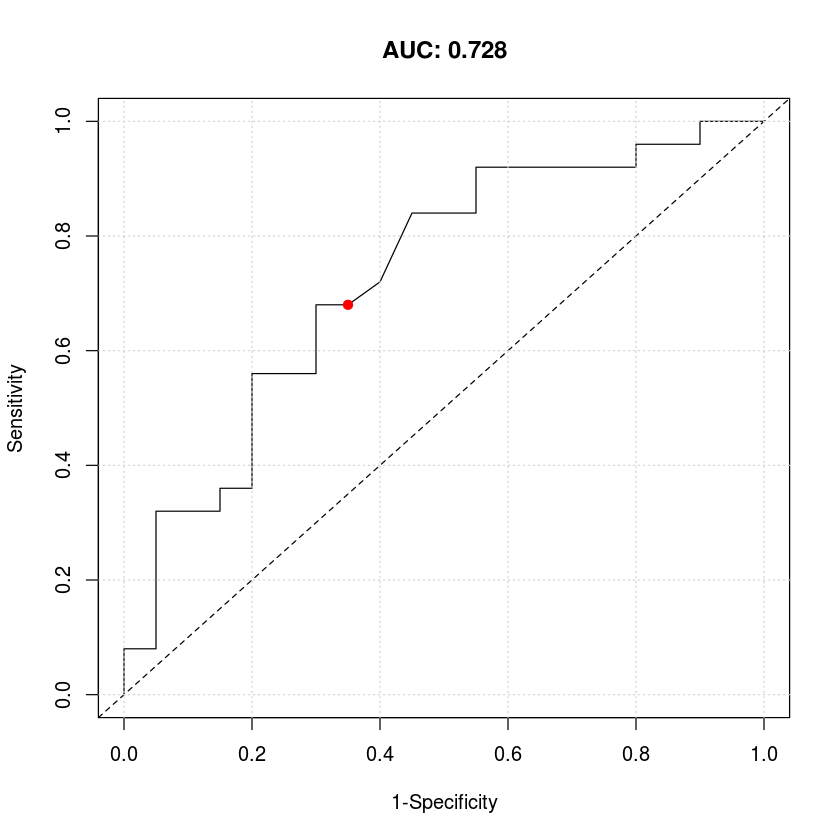

In [46]:
# AUC = Sum of area of trapezoids 
height = (SEN[-1]+SEN[-length(SEN)])/2  # 1/2(a+b)
width = -diff(1-SPE) #                  # h
auc = sum(height*width)

plot(1-SPE,SEN,type='l',xlab = '1-Specificity',ylab='Sensitivity',main= paste('AUC:', auc) )
abline(b = 1, a =0, lty=2)
grid()

paste('Max Accuracy =',round(max(ACC),3))
best_point = which(ACC == max(ACC))
paste('Max Sensitivity =',round(SEN[best_point],3))
paste('Max Specificity =',round(SPE[best_point],3))

points(x = 1-0.65, y = 0.68, col = 'red',pch = 19)